In [1]:
#Import libraries
import pytz
import numpy as np
import keras
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas_ta as ta
import MetaTrader5 as mt5
from datetime import datetime, timedelta, time
from tensorflow.keras.models import save_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

c:\Users\Angel\anaconda3\envs\proyect4\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (2.2.2) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
c:\Users\Angel\anaconda3\envs\proyect4\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [12]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# Initialize connection to the MetaTrader 5 terminal
if mt5.initialize():
    # Replace with your login credentials
    mt5.login(login=51863590, server="ICMarketsSC-Demo", password="1lfz&CJ7jyX2N8")
    timezone = pytz.timezone("America/Bogota")
    symbol = "US500"
    now = datetime.now(tz=timezone)
    # Retrieve monthly, weekly, and daily data
    data15 = mt5.copy_rates_range(symbol, mt5.TIMEFRAME_M15, datetime(2016, 1, 1), now)
    data5 = mt5.copy_rates_range(symbol, mt5.TIMEFRAME_M5, datetime(2022, 1, 1), now) #datetime(2024, 6, 1)
    data1 = mt5.copy_rates_range(symbol, mt5.TIMEFRAME_M1, datetime(2023, 8, 1), now) #20% MORE of rows as we'll try to predict 20%
    # Create DataFrames
    df_15 = pd.DataFrame(data15)
    df_5 = pd.DataFrame(data5)
    df_1 = pd.DataFrame(data1)
    #Truncate the data
    lenght = len(df_15)
    df_5 = df_5.tail(lenght)
    # df_1 = df_1.tail(lenght)
    #Create the RSI and EMA during a timestamp of 15 dayd and 22 days respectivelly
    # Calculate RSI and EMA
    df_15['rsi'] = ta.rsi(df_15['close'], length=8)
    df_15['ema'] = ta.ema(df_15['close'], length=22)
    df_5['rsi'] = ta.rsi(df_5['close'], length=8)
    df_5['ema'] = ta.ema(df_5['close'], length=22)
    df_1['rsi'] = ta.rsi(df_1['close'], length=8)
    df_1['ema'] = ta.ema(df_1['close'], length=22)
    # Fill NaN values
    df_15['rsi'].fillna(df_15['rsi'].mean(), inplace=True)
    df_15['ema'].fillna(df_15['ema'].mean(), inplace=True)
    df_5['rsi'].fillna(df_5['rsi'].mean(), inplace=True)
    df_5['ema'].fillna(df_5['ema'].mean(), inplace=True)
    df_1['rsi'].fillna(df_1['rsi'].mean(), inplace=True)
    df_1['ema'].fillna(df_1['ema'].mean(), inplace=True)
    print(f"Len Monthly: {len(df_15)}")
    print(f"Len Weekly: {len(df_5)}")
    print(f"Len Daily: {len(df_1)}")
    # Concatenate vertically
    df = pd.concat([df_15, df_5, df_1], ignore_index=True)
    columns_to_drop = ['spread', 'time', 'real_volume']
    df.drop(columns=columns_to_drop, inplace=True)
    #mt5.shutdown()
    # Now df_combined contains the concatenated data
    print(df.head(10))
    print(len(df))
else:
    print("Failed to initialize MetaTrader 5.")

Num GPUs Available:  1
Len Monthly: 181197
Len Weekly: 181197
Len Daily: 375541
     open    high     low   close  tick_volume        rsi          ema
0  2045.6  2051.1  1988.7  2017.7        12065  51.685609  3562.383154
1  2018.0  2025.2  2000.7  2019.0        10397  51.685609  3562.383154
2  2018.7  2020.8  1978.7  1995.2        12598  51.685609  3562.383154
3  1994.7  1998.7  1936.8  1941.3        16600  51.685609  3562.383154
4  1942.0  1972.3  1918.0  1919.7        17426  51.685609  3562.383154
5  1917.2  1936.5  1900.5  1921.0        17416  51.685609  3562.383154
6  1920.3  1947.8  1906.8  1931.1        16105  51.685609  3562.383154
7  1930.4  1954.0  1885.8  1890.5        15510  51.685609  3562.383154
8  1890.8  1934.6  1879.0  1919.9        18087  30.804507  3562.383154
9  1919.6  1927.9  1857.3  1884.0        20071  23.193450  3562.383154
737935


C:\Users\Angel\AppData\Local\Temp\ipykernel_31476\3145841972.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_15['rsi'].fillna(df_15['rsi'].mean(), inplace=True)
C:\Users\Angel\AppData\Local\Temp\ipykernel_31476\3145841972.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


In [13]:
#Create a test set
scaler = MinMaxScaler(feature_range=(0, 1))
# test = df['close'].tail(73368) #Number of minutes we're looking to predict for two months depending on the Market
# test_scaled = scaler.fit_transform(test.values.reshape((-1, 1)))
#Scale the train data
# train = df.head(len(df) - len(test)) #Rows we want to use to predict the data: total number of rows - minutes we want to predict
train_scaled = scaler.fit_transform(df.values.reshape((-1, 1)))
#Scale the test data
def create_dataset(dataset, N=120):
    X, Y = [], []
    for i in range(len(dataset) - N):
        X.append(dataset[i:(i + N), 0])
        Y.append(dataset[i + N, -1])
    return np.array(X), np.array(Y)
# Apply the new function
N = 120
X_train, y_train = create_dataset(train_scaled, N)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = y_train.reshape(-1, 1) #np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) #y_train.reshape(-1, 1)
print("Train shapes for X and y respectivelly", X_train.shape, y_train.shape)
print("Train sizes for X and y respectivelly", X_train.size, y_train.size)
print('Full time Lenght', len(df))

Train shapes for X and y respectivelly (5165425, 120, 1) (5165425, 1)
Train sizes for X and y respectivelly 619851000 5165425
Full time Lenght 737935


In [14]:
#Create the model (Optimized)
model = Sequential()
model.add(LSTM(30, recurrent_activation='sigmoid', activation='tanh', return_sequences=True, recurrent_dropout=0, unroll=False, use_bias=True, input_shape=(N, 1))) #(X_train.shape[1], 1) also works fine
model.add(Dropout(0.2))
model.add(LSTM(35, recurrent_activation='sigmoid', activation='tanh', return_sequences=True, recurrent_dropout=0, unroll=False, use_bias=True))
model.add(Dropout(0.2))
# model.add(LSTM(30, recurrent_activation='sigmoid', activation='tanh', return_sequences=True, recurrent_dropout=0, unroll=False, use_bias=True))
# model.add(Dropout(0.2))
# model.add(LSTM(40, recurrent_activation='sigmoid', activation='tanh', return_sequences=True, recurrent_dropout=0, unroll=False, use_bias=True))
# model.add(Dropout(0.2))
# model.add(LSTM(45, recurrent_activation='sigmoid', activation='tanh', return_sequences=True, recurrent_dropout=0, unroll=False, use_bias=True))
# model.add(Dropout(0.2))
# model.add(LSTM(45, recurrent_activation='sigmoid', activation='tanh', return_sequences=True, recurrent_dropout=0, unroll=False, use_bias=True))
# model.add(Dropout(0.2))
model.add(Dense(1))
model.summary()

# Check for NaNs in scaled data
print(f"Nan Values at the df: {np.isnan(df).sum()}")  # Should be 0
# Check for NaNs in training data
print(f"Nan Values at X_train: {np.isnan(X_train).sum()}")  # Should be 0
print(f"Nan Values at y_train: {np.isnan(y_train).sum()})")  # Should be 0

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 120, 30)           3840      
                                                                 
 dropout_2 (Dropout)         (None, 120, 30)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120, 35)           9240      
                                                                 
 dropout_3 (Dropout)         (None, 120, 35)           0         
                                                                 
 dense_1 (Dense)             (None, 120, 1)            36        
                                                                 
Total params: 13,116
Trainable params: 13,116
Non-trainable params: 0
_________________________________________________________________
Nan Values at the df: open           0
high       

In [5]:
# #Compile the model 
# model.compile(
#     loss='mean_squared_error',
#     optimizer=Adam(learning_rate=0.0001, clipvalue=1.0), 
#     metrics=['mae', keras.metrics.RootMeanSquaredError()],
#     run_eagerly=True
# )

# early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)                                  
# model.fit(X_train, y_train, epochs=100, batch_size=350, validation_split=0.2, callbacks=[early_stop])

#Save the Model
#save_model(model, 'Model13.keras', overwrite=True)

20/20 [==============================] - 1s 25ms/step
Test shapes for X and y respectivelly (610, 120, 1) (610, 120, 1)
Test sizes for X and y respectivelly 73200 73200
73200 (73200, 1)
73200 (73200, 1)
                        0
0     2024-08-26 10:08:07
1     2024-08-26 10:09:07
2     2024-08-26 10:10:07
3     2024-08-26 10:11:07
4     2024-08-26 10:12:07
...                   ...
63356 2024-10-25 10:04:07
63357 2024-10-25 10:05:07
63358 2024-10-25 10:06:07
63359 2024-10-25 10:07:07
63360 2024-10-25 10:08:07

[63361 rows x 1 columns]
Number of rows: 63361


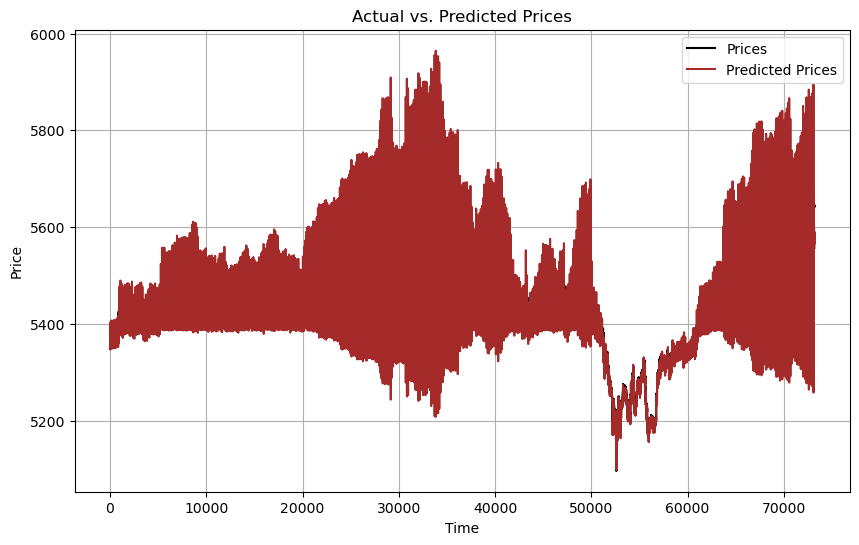

In [15]:
model = keras.models.load_model(r"C:\Users\Angel\OneDrive\Escritorio\Vs Code\.vscode\Model09.keras")
#CREATE A THE TEST DF
test = mt5.copy_rates_range(symbol, mt5.TIMEFRAME_M1, datetime(2024, 6, 1), now)
test = pd.DataFrame(test)
test = test['close'].tail(73368)
test_scaled = scaler.fit_transform(np.array(test).reshape(-1, 1))
_, X_test = create_dataset(test_scaled, N)
_, y_test = create_dataset(test_scaled, N)
#RESHAPE FOR PREDICTIONS
elements_two = X_test.size
divisible_two = (elements_two // 120) * 120
X_predict_shape = X_test[:divisible_two]
X_test = X_predict_shape.reshape(-1, 120, 1)

elements_one = y_test.size
divisible_one = (elements_one // 120) * 120
y_predict_shape = y_test[:divisible_one]
y_test = y_predict_shape.reshape(-1, 120, 1)

y_pred = model.predict(X_test)
# Inverse scaling
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_real = scaler.inverse_transform(y_test.reshape(-1, 1))
# y_pred_trimmed = y_pred[:len(y_real)] #Match the sizes
# y_real_trimmed = y_real[:len(y_pred)]
print("Test shapes for X and y respectivelly", X_test.shape, y_test.shape)
print("Test sizes for X and y respectivelly", X_test.size, y_test.size)
print(len(y_pred), y_pred.shape)
print(len(y_real), y_real.shape)
# Plot the results
now = datetime.now()
sixty_days = now + timedelta(days=60)
sixty_days = sixty_days.replace(microsecond=0)
date_range = pd.date_range(start=now.replace(microsecond=0), end=sixty_days, freq='1min')
date_range = date_range[date_range.dayofweek < 5]
time_df = pd.DataFrame(date_range)
rows = len(time_df)
print(time_df)
print(f"Number of rows: {(rows)}")
plt.figure(figsize=(10, 6))
plt.plot(y_real, label='Prices', color='black')
plt.plot(y_pred, label='Predicted Prices', color='brown')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Prices')
plt.grid(True)
plt.legend()
plt.show()

In [7]:
# minute_1 = df_1.tail(100)
# minute_1.drop(columns=columns_to_drop, inplace=True)
# minute_2 = df_5.tail(100)
# minute_2.drop(columns=columns_to_drop, inplace=True)
# minute_3 = df_15.tail(100)
# minute_3.drop(columns=columns_to_drop, inplace=True)
# merge = pd.concat([minute_1, minute_2, minute_3], ignore_index=True, axis=1).fillna(method='bfill')
# a = np.array(merge)
# window_data = a[-rows:]
# elements = window_data.size
# divisible = (elements // 120) * 120
# u = a[:divisible]
# print(np.isnan(a).sum())
# print(len(u), u.shape)

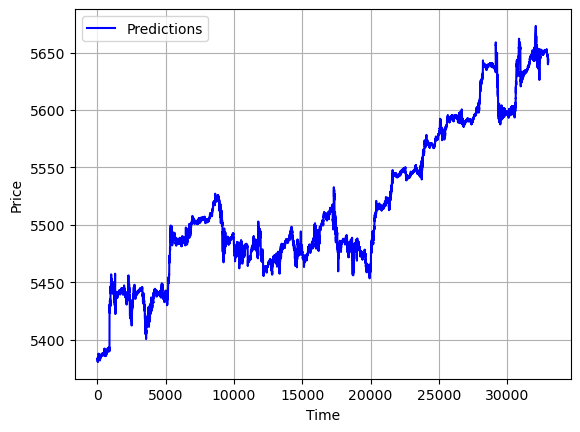

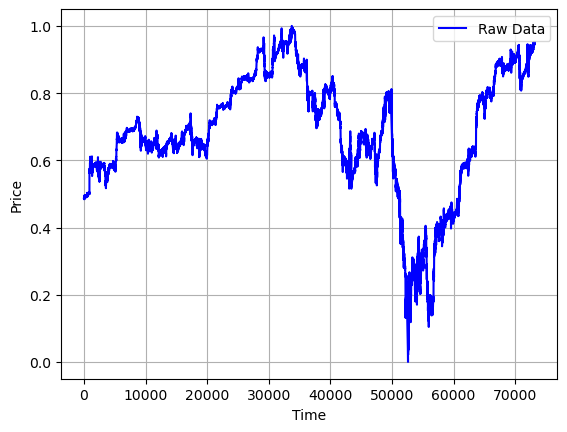

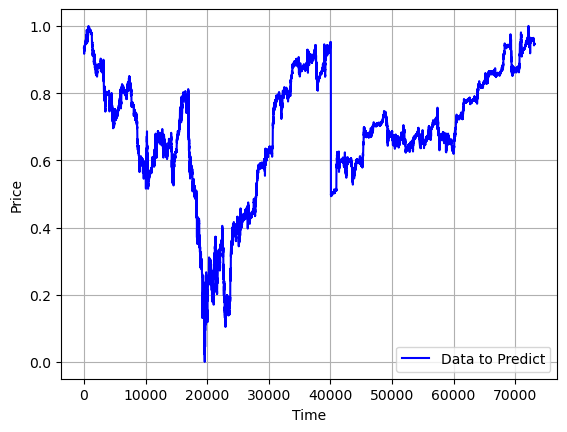

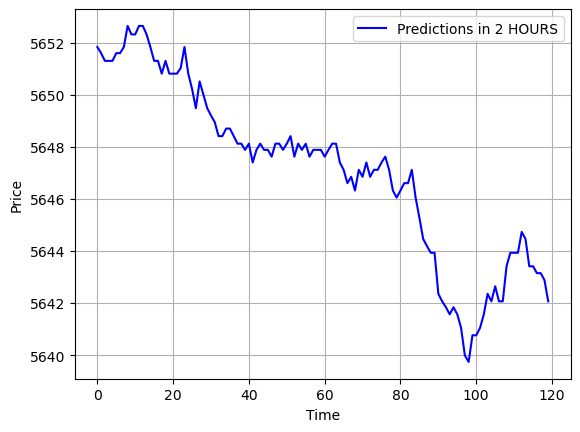

Preictions with the model of 15k parameters


In [17]:
#Get the models
model1 = keras.models.load_model(r"C:\Users\Angel\OneDrive\Escritorio\Vs Code\.vscode\Model11.keras")
# Initialize predictions list
import math
batch_size = 60
M = 33000
R = 960  #  840=7500,  
timestamps = 1 #R // 60
predictions = []
window_data = X_test[-R:] #600 10
for i in range(M):
    prediction = model.predict(window_data.reshape(-1, N, 1), batch_size= batch_size, verbose=0)  # Reshape for LSTM
    predictions.append(prediction[0, 0])  
    window_data = np.roll(window_data, -timestamps)  # Shift data by one time step
    window_data[-timestamps] = prediction[0, 0]  # Update last value with prediction
    if len(prediction) > M:
        break
q = np.array(predictions).reshape(-1, 1)
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
# To show the real values   real = scaler.inverse_transform(np.array(window_data).reshape(-1, 1))
if np.isnan(predictions).sum() == 0:
    plt.plot(predictions, color='blue', label='Predictions')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("Predictions contain NaN values.")
if np.isnan(X_test[-R:].reshape(-1, 1)).sum() == 0:
    plt.plot(X_test[-R:].reshape(-1, 1), color='blue', label='Raw Data')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("Real Data contain NaN values.")
if np.isnan(window_data.reshape(-1, 1)).sum() == 0:
    plt.plot(window_data.reshape(-1, 1), color='blue', label='Data to Predict')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("Real Data contain NaN values.")
if np.isnan(predictions[-120:]).sum() == 0:
    plt.plot(predictions[-120:], color='blue', label='Predictions in 2 HOURS')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("Real Data contain NaN values.")
print('Preictions with the model of 15k parameters')
#Model of 15K Parameters
# predictions1 = []
# window_d1 = X_test[-R:] #7200 #600 10
# for i in range(M):
#     prediction1 = model1.predict(window_d1.reshape(-1, N, 1) ,batch_size= batch_size, verbose=0)  # Reshape for LSTM
#     predictions1.append(prediction1[0, 0])  
#     window_d1 = np.roll(window_d1, -timestamps)  # Shift data by one time step
#     window_d1[-timestamps] = predictions1[0]  # Update last value with prediction
#     if len(prediction1) > M:
#         break
# w = np.array(predictions1).reshape(-1, 1)
# predictions1 = scaler.inverse_transform(np.array(predictions1).reshape(-1, 1))
# z = np.concatenate((predictions, predictions1))
# if np.isnan(predictions1).sum() == 0:
#     plt.plot(predictions1, color='orange', label='Predictions')
#     plt.xlabel('Time')
#     plt.ylabel('Price')
#     plt.grid(True)
#     plt.legend()
#     plt.show()
# else:
#     print("Predictions contain NaN values.")
# if np.isnan(X_test[-R:].reshape(-1, 1)).sum() == 0:
#     plt.plot(X_test[-R:].reshape(-1, 1), color='orange', label='Raw Data')
#     plt.xlabel('Time')
#     plt.ylabel('Price')
#     plt.grid(True)
#     plt.legend()
#     plt.show()
# else:
#     print("Real Data contain NaN values.")
# if np.isnan(window_d1.reshape(-1, 1)).sum() == 0:
#     plt.plot(window_d1.reshape(-1, 1), color='orange', label='Data to Predict')
#     plt.xlabel('Time')
#     plt.ylabel('Price')
#     plt.grid(True)
#     plt.legend()
#     plt.show()
# else:
#     print("Real Data contain NaN values.")
# if np.isnan(predictions1[-120:]).sum() == 0:
#     plt.plot(predictions1[-120:], color='orange', label='Predictions in 2 HOURS')
#     plt.xlabel('Time')
#     plt.ylabel('Price')
#     plt.grid(True)
#     plt.legend()
#     plt.show()
# else:
#     print("Real Data contain NaN values.")

In [18]:
#Other way to make predictions during two months
# Prepare input data for predictions
# two = df['close']
# two = np.array(two[-N:]).reshape(-1, N, 1)
# input_data = np.concatenate(scaler.fit_transform(two), X_test)
# X_predict, _ = create_dataset(dataset=input_data,N= N)
# print(X_predict.shape)


#Predictions with total new dataframe
# data = mt5.copy_rates_range(symbol, mt5.TIMEFRAME_M1, datetime(2024, 6, 1), now)
# d = pd.DataFrame(data=data)
# d = scaler.fit_transform(d['close'].values.reshape((-1, 1)))
# _, d_1 = create_dataset(d, N) #Needs to be on the Y axis
# predictions = []
# window_data = d_1[-R:]

# for i in range(5000):
#     prediction = model.predict(window_data.reshape(-1, N, 1), batch_size= batch_size, verbose=0)  # Reshape for LSTM
#     predictions.append(prediction[0, 0])  
#     window_data = np.roll(window_data, -timestamps)  # Shift data by one time step
#     window_data[-timestamps] = prediction[0, 0]  # Update last value with prediction
# predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# plt.plot(predictions, color='gray', label='Predictions')
# plt.xlabel('Time') 
# plt.ylabel('Price')
# plt.grid(True)
# plt.legend()
# plt.show()

# plt.plot(window_data, color='green', label='Input Data')
# plt.xlabel('Time')
# plt.ylabel('Price')
# plt.grid(True)
# plt.legend()
# plt.show()

# plt.plot(predictions[-100:], color='gray', label='Predictions during 2 HOURS')
# plt.xlabel('Time') 
# plt.ylabel('Price')
# plt.grid(True)
# plt.legend()
# plt.show()

#SAVE THE DATAFRAMES
stock_prices_df = pd.DataFrame(predictions)
minutes_predicted = len(predictions)
#Create a new full dataframe to be used in our trading bot.
full_df = pd.concat([time_df, stock_prices_df], axis='columns')
full_df = full_df.reset_index().drop_duplicates(subset='index', keep='last').set_index('index')
full_df = full_df[:minutes_predicted]
full_df.columns = ['Date', 'Price']
full_df['Price'] = full_df['Price'].astype(float).round(8)

#Save the dataframe
full_df.to_csv("ETHUSD30.csv", index=False)
print(full_df.duplicated)

<bound method DataFrame.duplicated of                      Date        Price
index                                 
0     2024-08-26 10:08:07  5383.215332
1     2024-08-26 10:09:07  5383.502930
2     2024-08-26 10:10:07  5383.792969
3     2024-08-26 10:11:07  5383.792969
4     2024-08-26 10:12:07  5383.215332
...                   ...          ...
32995 2024-09-26 08:03:07  5643.411133
32996 2024-09-26 08:04:07  5643.148438
32997 2024-09-26 08:05:07  5643.148438
32998 2024-09-26 08:06:07  5642.883301
32999 2024-09-26 08:07:07  5642.066406

[33000 rows x 2 columns]>
